Synthesize Criteo data using a gaussian mixture model and sequential multinomial logit models. (Note that this file uses the updated synthesis and optimization functions from the `helper_functions.py` file.).

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import sys

# Add the parent directory to path
sys.path.append('..')

# Then import
from helper_functions import *

rng = np.random.RandomState(42)

configure_parallel_environment()

OMP_NUM_THREADS set to 1
LOKY_MAX_CPU_COUNT set to 20 cores


20

Import Criteo data.

In [2]:
train_data = pd.read_csv("../../Data/Criteo/cleaned_criteo.gz", 
                 compression='gzip', 
                 sep='\,',
                 header=0)

C:\Users\camer\AppData\Local\Temp\ipykernel_3772\2941239941.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv("../../Data/Criteo/cleaned_criteo.gz",


View confidential data to synthesize.

In [3]:
train_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,2.534995,2.308533,2.194602,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
1,2.534995,2.308533,2.197523,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
2,2.534995,2.308533,2.193303,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
3,2.534995,2.308533,2.197536,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
4,2.534995,2.308533,2.201438,107.757316,2.330251,61.279994,1.342378e+00,1.575636,52.216366,2.579463,1.667778,0.84478,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,3.269484,2.308533,2.197919,107.757316,2.330251,61.279994,3.754896e-02,1.575636,46.505852,2.579463,1.667778,0.84478,1,0,0,0
13979588,2.537041,2.368327,2.105887,0.182664,2.330251,20.349663,8.696717e-07,1.835621,53.083067,2.579463,1.667778,0.84478,1,0,0,1
13979589,2.563144,2.308533,2.126071,2.322030,2.400581,61.279994,2.530380e-04,1.575636,43.781534,3.159982,1.819567,0.84478,1,0,1,0
13979590,3.211048,2.308533,2.105887,107.757316,2.330251,61.279994,2.757648e-01,1.575636,53.083067,2.579463,1.667778,0.84478,1,0,0,0


Define order of synthesis. We first synthesize the joint distribution of the numeric features `f0`-`f11` using a Gaussian mixture model, followed by `treatment`, `exposure`, `visit` and `conversion` synthesized by sequential multinomial logit models.

In [4]:
# synthesis steps
# written as a list of tuples (features, model)
synthesis_steps = [
    (['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'], 'gmm'),
    ('treatment', 'multinomial'),
    ('exposure', 'multinomial'),
    ('visit', 'multinomial'),
    ('conversion', 'multinomial')
]

Set up dictionary of parameter bounds for the Bayesian optimization process. The current state of the code requires a set of bounds for each parameter being optimized.

In [5]:
# parameter bounds
param_bounds = {
    'gmm': {
        'num_components': (10, 100.99),
    },
    'multinomial': {
        'treatment': {'C': (0.001, 3)},
        'exposure': {'C': (0.001, 3)},
        'visit': {'C': (0.001, 3)},
        'conversion': {'C': (0.001, 3)}
    }
}

Define additional parameters of the optimization process:

- num_synthetic_datasets: Number of synthetic datasets to generate on each iteration of the optimizer
- num_iter_optimization: Number of iterations to run the optimizer
- num_init_optimization: Number of initializations to perform prior to optimized iterations
- random_states: run the optimizer all the way through for each random seed in this list

In [6]:
number_synthetic_datasets=10
num_iter_optimization=25
num_init_optimization=5
random_states = [1006, 428]

Use the `optimization_models` function to perform the optimized synthesis process. The function returns the objective value associated with each iteration, the best set of parameters for each random seed, and the final optimization object from the Bayesian optimization function.

In [ ]:
optimization_results = [optimize_models(train_data=train_data, 
                                        number_synthetic_datasets=number_synthetic_datasets,
                                        synthesis_steps=synthesis_steps,
                                        param_bounds=param_bounds,
                                        random_state=r,
                                        num_iter_optimization=num_iter_optimization,
                                        num_init_optimization=num_init_optimization) for r in random_states]

|   iter    |  target   |    x0     |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------------------


In [ ]:
run_targets = [np.minimum.accumulate(-i['optimizer'].space.target) for i in optimization_results]

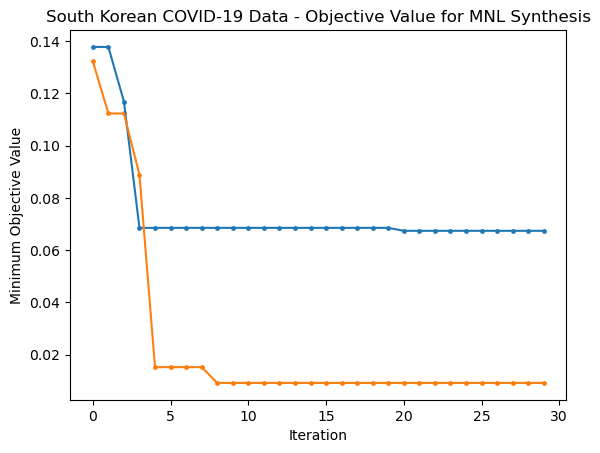

In [ ]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("South Korean COVID-19 Data - Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

In [14]:
optimization_results

[{'best_params': {'gmm': {'num_components': 54},
   'multinomial': {'sex': {'C': np.float64(1.9477600882029753)},
    'age': {'C': np.float64(1.2666567499200732)},
    'state': {'C': np.float64(0.32041438264804734)}}},
  'best_score': np.float64(0.06738128654490763),
  'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization at 0x22ca70ed090>},
 {'best_params': {'gmm': {'num_components': 69},
   'multinomial': {'sex': {'C': np.float64(2.99760152262256)},
    'age': {'C': np.float64(0.05078359805633225)},
    'state': {'C': np.float64(0.8489720564774512)}}},
  'best_score': np.float64(0.009185595310751919),
  'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization at 0x22ca70ee850>}]

In [20]:
best_params = optimization_results[np.argmin([x['best_score'] for x in optimization_results])]['best_params']

In [21]:
best_params

{'gmm': {'num_components': 69},
 'multinomial': {'sex': {'C': np.float64(2.99760152262256)},
  'age': {'C': np.float64(0.05078359805633225)},
  'state': {'C': np.float64(0.8489720564774512)}}}

In [22]:
full_ratios, full_sXs = perform_synthesis(
    train_data=train_data,
    number_synthetic_datasets=20,
    synthesis_steps=synthesis_steps,
    param_values=best_params
)

c:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
np.mean(full_ratios)

np.float64(0.8590377663770157)

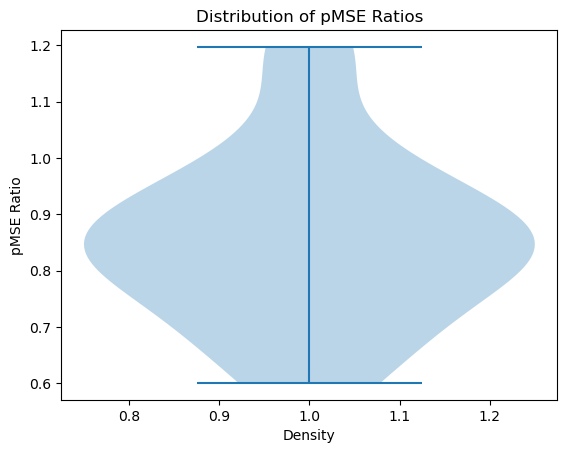

In [24]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

In [25]:
synthetic_data_path = "../../Data/SK/"

for i, sX in enumerate(full_sXs):
    if not os.path.exists(synthetic_data_path):
        os.makedirs(synthetic_data_path)
    sX.to_csv(synthetic_data_path + "mnl_" + str(i) + ".csv", index=False)

End of file.